In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import cv2

In [2]:
data = 'C:/Users/Tejeswara Reddy/OneDrive/Desktop/New folder (2)/leukumia dataset'
No_leukemia = 'C:/Users/Tejeswara Reddy/OneDrive/Desktop/New folder (2)/leukumia dataset/hem'
Yes_leukemia = 'C:/Users/Tejeswara Reddy/OneDrive/Desktop/New folder (2)/leukumia dataset/all'

In [3]:
dirlist=[No_leukemia, Yes_leukemia]
classes=['No', 'Yes']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  10661    labels:  10661


In [4]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,C:/Users/Tejeswara Reddy/OneDrive/Desktop/New ...,No
1,C:/Users/Tejeswara Reddy/OneDrive/Desktop/New ...,No
2,C:/Users/Tejeswara Reddy/OneDrive/Desktop/New ...,No
3,C:/Users/Tejeswara Reddy/OneDrive/Desktop/New ...,No
4,C:/Users/Tejeswara Reddy/OneDrive/Desktop/New ...,No


In [5]:
print(df['labels'].value_counts())

Yes    7272
No     3389
Name: labels, dtype: int64


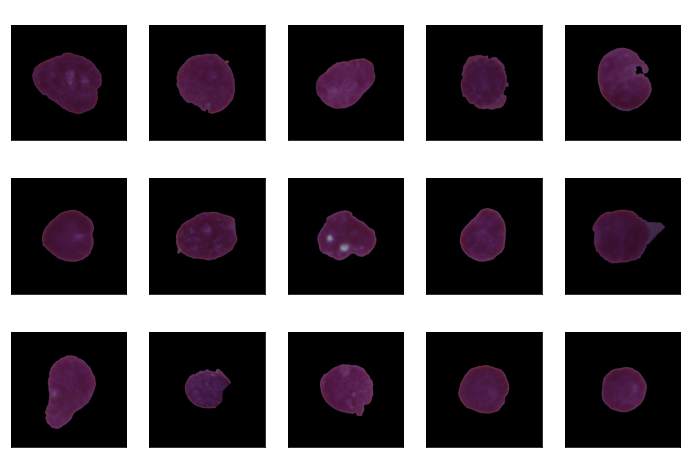

In [6]:
plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [7]:
from sklearn.model_selection import train_test_split


train, test = train_test_split(df, train_size=0.95, random_state=0)
train_new, valid = train_test_split(train, train_size=0.90, random_state=0)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (9114, 2)
test set shape: (534, 2)
validation set shape: (1013, 2)


In [8]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [9]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (224,224), batch_size = 32, 
                                              class_mode = 'binary', shuffle = True)
val_gen = train_datagen.flow_from_dataframe(valid, 
                                            target_size=(224,224), x_col = 'filepaths', y_col ='labels', 
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (224,224), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)

Found 9114 validated image filenames belonging to 2 classes.
Found 1013 validated image filenames belonging to 2 classes.
Found 534 validated image filenames belonging to 2 classes.


In [10]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

In [11]:
from tensorflow import keras
base_model = keras.applications.ResNet50V2(
    weights="imagenet", 
    input_shape=(224, 224, 3),
    include_top=False,
)
base_model.trainable = False
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 2,049
Non-trainable params: 23,564,800
_____________________________________________

In [12]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("leukemia_model.h5", save_best_only=True, verbose = 0)
]


model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate= 0.0001), metrics=['accuracy'])


history = model.fit(train_gen, validation_data = val_gen, epochs = 10, callbacks = [callbacks], verbose = 1)

Epoch 1/10
285/285 [==============================] - 408s 1s/step - loss: 0.6024 - accuracy: 0.6835 - val_loss: 0.5307 - val_accuracy: 0.7473
Epoch 2/10
285/285 [==============================] - 350s 1s/step - loss: 0.5277 - accuracy: 0.7546 - val_loss: 0.4961 - val_accuracy: 0.7651
Epoch 3/10
285/285 [==============================] - 308s 1s/step - loss: 0.5092 - accuracy: 0.7718 - val_loss: 0.4866 - val_accuracy: 0.7769
Epoch 4/10
285/285 [==============================] - 427s 1s/step - loss: 0.4971 - accuracy: 0.7722 - val_loss: 0.4668 - val_accuracy: 0.7818
Epoch 5/10
285/285 [==============================] - 260s 912ms/step - loss: 0.4881 - accuracy: 0.7840 - val_loss: 0.4756 - val_accuracy: 0.7966
Epoch 6/10
285/285 [==============================] - 256s 898ms/step - loss: 0.4838 - accuracy: 0.7830 - val_loss: 0.4604 - val_accuracy: 0.8036
Epoch 7/10
285/285 [==============================] - 252s 885ms/step - loss: 0.4808 - accuracy: 0.7858 - val_loss: 0.4737 - val_accurac

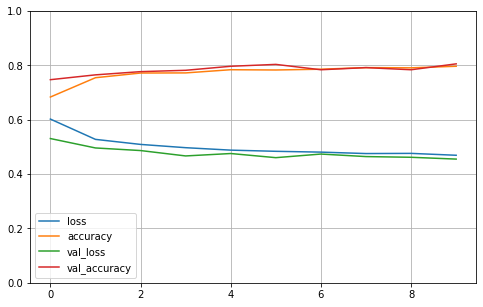

In [13]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [14]:
model.save('leukemia_model.h5')